Using Simple CNN Model
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 730ms/step - accuracy: 0.5606 - loss: 0.6614 - val_accuracy: 0.6900 - val_loss: 0.5982
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 641ms/step - accuracy: 0.6874 - loss: 0.5994 - val_accuracy: 0.6900 - val_loss: 0.5948
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 627ms/step - accuracy: 0.6991 - loss: 0.5923 - val_accuracy: 0.6900 - val_loss: 0.5928
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 630ms/step - accuracy: 0.7055 - loss: 0.5728 - val_accuracy: 0.6900 - val_loss: 0.5803
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 681ms/step - accuracy: 0.6971 - loss: 0.5739 - val_accuracy: 0.6900 - val_loss: 0.5614
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 679ms/step - accuracy: 0.7242 - loss: 0.5126 - val_accuracy: 0.7500 - val_loss: 0.5294
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 669ms/step - accuracy: 0.7514 - loss: 0.5152 - val_accuracy: 0.7900 - val_loss: 0.5422
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 687ms/step - accuracy: 0.7982 - los

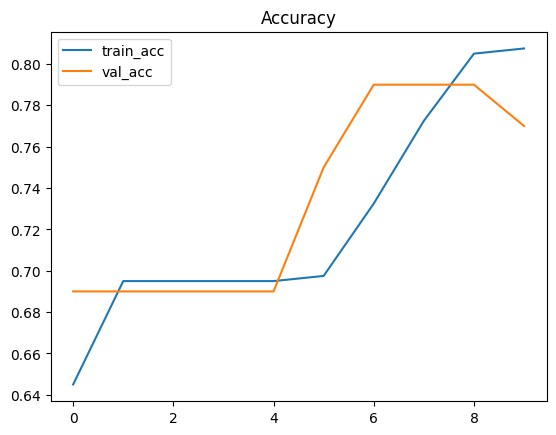

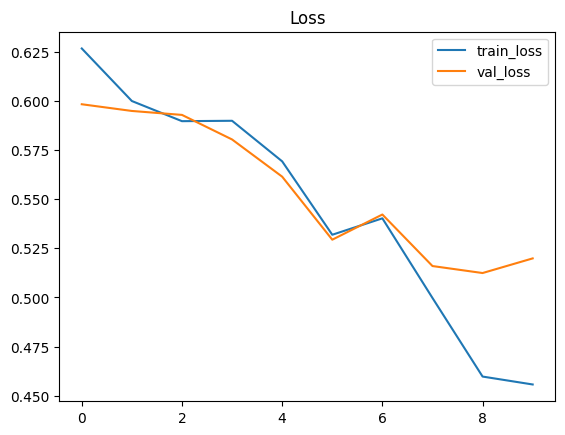

In [4]:
"""
Cancer Detection Using Histopathological Images
-----------------------------------------------
- Dataset: Breast Cancer Histopathology (Kaggle subset, e.g. 500 images)
- Preprocessing: Resize to 128x128, normalize [0,1]
- Model: Simple CNN (3 conv layers), train 10 epochs
- Evaluation: Accuracy & Loss
- Bonus: Transfer Learning with VGG16
"""

import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

# -----------------------------
# Parameters
# -----------------------------
# ✅ Path to extracted Kaggle dataset
DATA_DIR = "/root/.cache/kagglehub/datasets/paultimothymooney/breast-histopathology-images/versions/1/IDC_regular_ps50_idx5"

IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 10
SUBSET_SIZE = 500  # approx number of images
USE_VGG16 = False  # set True for transfer learning

# -----------------------------
# Discover dataset (adjusted for Kaggle structure)
# -----------------------------
def discover_images(data_dir):
    benign_files = []
    malignant_files = []
    for root, dirs, files in os.walk(data_dir):
        for f in files:
            if f.lower().endswith((".png", ".jpg", ".jpeg")):
                # Parent folder is '0' (benign) or '1' (malignant)
                parent = os.path.basename(root)
                if parent == "0":
                    benign_files.append((os.path.join(root, f), "benign"))
                elif parent == "1":
                    malignant_files.append((os.path.join(root, f), "malignant"))
    all_files = benign_files + malignant_files
    classes = ["benign", "malignant"]
    return all_files, classes

files, classes = discover_images(DATA_DIR)
random.shuffle(files)
files = files[:SUBSET_SIZE]

class_to_index = {c: i for i, c in enumerate(classes)}
X = [f for f, _ in files]
y = [class_to_index[c] for _, c in files]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# -----------------------------
# TF Dataset Loader
# -----------------------------
AUTOTUNE = tf.data.AUTOTUNE

def make_dataset(filepaths, labels, training=False):
    ds_paths = tf.data.Dataset.from_tensor_slices(filepaths)
    ds_labels = tf.data.Dataset.from_tensor_slices(labels)
    ds = tf.data.Dataset.zip((ds_paths, ds_labels))

    def _load(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
        img = tf.cast(img, tf.float32) / 255.0
        return img, label

    ds = ds.map(_load, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.shuffle(500).map(lambda x, y: (tf.image.random_flip_left_right(x), y))
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, y_train, training=True)
val_ds = make_dataset(X_val, y_val, training=False)

# -----------------------------
# Model Definitions
# -----------------------------
input_shape = (IMG_SIZE, IMG_SIZE, 3)
num_classes = len(classes)

def build_simple_cnn():
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, 3, activation="relu", padding="same"),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation="relu", padding="same"),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation="relu", padding="same"),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu"),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

def build_vgg16_tl():
    base = keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=input_shape)
    base.trainable = False
    inputs = keras.Input(shape=input_shape)
    x = keras.applications.vgg16.preprocess_input(inputs * 255.0)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

# -----------------------------
# Training
# -----------------------------
if USE_VGG16:
    model = build_vgg16_tl()
    print("Using VGG16 Transfer Learning Model")
else:
    model = build_simple_cnn()
    print("Using Simple CNN Model")

history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

# -----------------------------
# Evaluation
# -----------------------------
loss, acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {acc:.4f}, Loss: {loss:.4f}")

# -----------------------------
# Plotting
# -----------------------------
plt.figure()
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend()
plt.title("Accuracy")
plt.savefig("accuracy.png")

plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss")
plt.savefig("loss.png")

print("Training complete. Plots saved as accuracy.png and loss.png")
print("Path to dataset files:", DATA_DIR)
